<a href="https://colab.research.google.com/github/mthomp89/landslide-detect/blob/main/BIG_SUR_Landslide_Version_of_Detecting_Changes_in_Sentinel_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Integrating Synthetic Aperature Radar Imagery in Landslide Detection</center>
 <table><tr><td>By Leah Manak and Mitchell Thompson</td></tr></table>
  <table><tr><td>Special Credit to Elsa Culler</td></tr></table>
  <table><tr><td>June, 2022</td></tr></table>




# In this Notebook:
 1. Setup
 - 1.1 Initialize Google Earth Engine
 - 1.2 Import Datasets and Python Modules
 - 1.3 Set Working Directory
 2. Verified Landslides: Database Setup and Location Map
 - 2.1 Create Geopandas Dataframe
 - 2.2 Entire Landslides Catalog Folium Map
 - 2.3 Establish AOI
 3. Sentinal-1 Radar Imagery
 - 3.1 Process significant changes
 4. Discussion
 5. References

# Setup

### Initialize Google Earth Engine

Run the following cell to initialize the API. The output will contain instructions on how to grant this notebook access to Earth Engine using your account.

In [1]:
import ee
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code: 4/1AX4XfWiej8DFKohsQVePSJudV8i4flRBg0kyo7EzxYOWFexQzWtEkVB7eSc

Successfully saved authorization token.


### Datasets and Python modules
One [dataset](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD) that will be used in the tutorial is:

- COPERNICUS/S1_GRD_FLOAT
    - Sentinel-1 ground range detected images

Another is a verified landslide locations dataset created by CU Boulder Earth Lab that will be defined below as "landslide_df". 
- This dataset includes various verified locations of landslides across North America with descriptions of severity and type. 
The following cell imports some python modules which we will be using as we go along and enables inline graphics.

The following cell imports various Python modules necessary to complete this notebook

In [157]:
import os

import json
import earthpy as et
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import shapely.geometry as sgeo
from shapely.geometry import Point
from src.det import det
from src.create_dataframe import create_dataframe
from src.image_search import image_search
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
import geemap.foliumap as geemap
import ipyleaflet
import ipywidgets

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None, )

# Enable inline graphics
%matplotlib inline

### Set working directory

In [158]:
# Change directory to landslide-detect data path
data_path = os.path.join(et.io.HOME, "earth-analytics", "landslide-detect")
if os.path.exists(data_path):
    os.chdir(data_path)
else:
    os.makedirs(data_path)
    print('The new directory is created!')
    os.chdir(data_path)

print('Current working directory is set to: ', os.getcwd())

Current working directory is set to:  /Users/leahmanak/earth-analytics/landslide-detect


# Verified Landslides: Database Setup and Location Map

### Create Geodataframe

Earlier in the imports area, we imported a custom function to create a 
GeoPandas DataFrame. Here we call that function.

In [1371]:
def create_geodataframe(data_file):
    """
    Reads a csv file into a GeoPandas DataFrame. Sets the index to the 'slide.id'
    and sorts the geoDataFrame by the new index. Converts the date+time column to
    a timezone aware DateTime object. Inserts two columns DateTime columns to
    that are 180 days left and right of event date. Adds a column to combine 
    reported coordinates into a list. Converts the reported  coordinates to 
    a geoPandas geometry point.
    Parameters
    ----------
    data_file : str
    Returns
    -------
    dataframe
        sorted by index
    """

    gdf = gpd.read_file(data_file)

    # Add event point column as tuple
    gdf['ctr_point'] = gdf['lon'] + ', ' + gdf['lat']

    # Convert reported coordinates to geometry
    gdf[['lon', 'lat']] = gdf[['lon', 'lat']].astype(float)
    geometry = [Point(xy) for xy in zip(gdf.lon, gdf.lat)]
    gdf = GeoDataFrame(gdf, crs="EPSG:4326", geometry=geometry)

    return gdf

# Open CSV and Create DataFrame with Pandas
landslide_gdf = create_geodataframe('landslides.verified.csv')
landslide_gdf.head(2)

,slide.id,slide.date,location,type,trigger,size,lon,lat,location_accuracy,event_title,admin_division_name,ge.lat,ge.lon,is.exact,slide.index,geometry,ctr_point
0,8321,2015-09-21T00:00:00Z,"Birken, BC, Canada",landslide,downpour,medium,-122.620500,50.479000,5km,"Birken, BC, Canada",British Columbia,NA,NA,FALSE,1,POINT (-122.62050 50.47900),"-122.6205, 50.479"
1,7757,2015-12-07T18:00:00Z,Edmonds,mudslide,rain,medium,-122.380528,47.706794,5km,Edmonds,Washington,47.70679444444445,-122.38052777777777,TRUE,2,POINT (-122.38053 47.70679),"-122.38052777777777, 47.70679444444445"


### Folium Map of All Verified Landslide Locations

In [1372]:
# Display all verified landslides in folium. We will need to replace this to match function in cell above
verified_locations = landslide_gdf[["slide.id",
                                    "slide.date",
                                    "lat",
                                    "lon",
                                    "type"]]

mp = folium.Map(
    location=[verified_locations.lat.mean(), verified_locations.lon.mean()],
    zoom_start=4,
    control_scale=True,
    tiles="Stamen Terrain")

for index, location_info in landslide_gdf.iterrows():
    folium.Marker([location_info["lat"], location_info["lon"]],
                  popup=(f"Slide ID: {location_info['slide.id']}\n"
                  f"Size: {location_info['size']}\n"
                  f"Cause: {location_info['type']}"),
                  icon=folium.Icon(color='red', prefix='fa',
                  icon='exclamation-triangle')).add_to(mp)

display(mp)

## Establish AOI 

In [1648]:
## INTEGRATE

class Coord:
    """Access coordinates in either order"""

    def __init__(self, lon, lat):
        self.lon = lon
        self.lat = lat
        self.xy = [self.lon, self.lat]
        self.yx = [self.lat, self.lon]
        self.marker = folium.Marker(location=self.yx)

class BBox:
    """Bounding box available in many formats"""
    def __init__(self, minx, miny, maxx, maxy):
        self.minx, self.miny = (minx, miny)
        self.maxx, self.maxy = (maxx, maxy)
        self.box = sgeo.box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)
        self.coords = list(self.box.exterior.coords)
        self.ee = ee.Geometry.Polygon(self.coords)
        self.geojson = self.box.__geo_interface__
        self.folium = folium.GeoJson(self.geojson)
        self.folium_bounds = [(y, x) for (x, y) in self.coords]

In [1649]:
# INTEGRATE

# Prompt user for AOI by GLC slide ID
location = input('Enter desired NASA Global Land Slide identification number: ')
# Grab location from gdf
while True:
    try:
        # loc = landslide_gdf.loc[location]
        loc = landslide_gdf[(landslide_gdf == location)]
    except KeyError: 
        print("You have entered an invalid GLC Slide ID number, please try again.")
    break

new_df = landslide_gdf[(landslide_gdf['slide.id'] == location)]
lon = new_df['lon'].values[0]
lat = new_df['lat'].values[0]

new_df

Enter desired NASA Global Land Slide identification number: 10231


,slide.id,slide.date,location,type,trigger,size,lon,lat,location_accuracy,event_title,admin_division_name,ge.lat,ge.lon,is.exact,slide.index,geometry,ctr_point
134,10231,2016-12-15T14:22:00Z,Landslide on Highway 299,landslide,rain,medium,-123.311272,40.780147,1km,Landslide on Highway 299,NA,40.78014722222222,-123.31127222222221,TRUE,153,POINT (-123.31127 40.78015),"-123.31127222222221, 40.78014722222222"


In [1650]:
# # INTEGRATE


event_loc = Coord(lon=lon, lat=lat)

# Approximately 1km buffer
# buffer = Coord(lon=0.01, lat=0.008)
buffer = Coord(lon=0.013, lat=0.009)

bbox = BBox(
    minx=event_loc.lon - buffer.lon, miny=event_loc.lat - buffer.lat,
    maxx=event_loc.lon + buffer.lon, maxy=event_loc.lat + buffer.lat
)

In [1651]:
# # INTEGRATE


BASE_DATE = ee.Date(new_df['slide.date'].values[0][0:10])

# Select 1 year surrounding the event
start_date = BASE_DATE.advance(-180, 'days')
end_date = BASE_DATE.advance(180, 'days')

'Event date is {}, Sentinel-1 image data range is between {} and {}'.format(
    BASE_DATE.format('YYYY-MM-dd').getInfo(),
    start_date.format('YYYY-MM-dd').getInfo(), 
    end_date.format('YYYY-MM-dd').getInfo())

'Event date is 2016-12-15, Sentinel-1 image data range is between 2016-06-18 and 2017-06-13'

In [1652]:
aoi = bbox.ee
location = aoi.centroid().coordinates().getInfo()[::-1]
split_view = geemap.Map(location=location, zoom_start=15)
split_view.split_map(left_layer='SATELLITE', right_layer= 'USGS NAIP Imagery False Color')

split_view

![Sentinal-1](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSnEbm9fwTfAgz9UTlwD8_CD59LawTUhN2maA&usqp=CAU)
# Introducing Sentinal-1 Radar Imagery

SENTINEL-1 is an imaging radar mission providing continuous all-weather, day-and-night imagery at C-band. The SENTINEL-1 constellation provides high reliability, improved revisit time, geographical coverage and rapid data dissemination to support operational applications in the priority areas of marine monitoring, land monitoring and emergency services [1].

In this notebook we utilize the [COPERNICUS/S1_GRD_FLOAT](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD#bands) Earth Engine image collection. 

## Sattelite Image Collection and Preparation 
Below is a function that iterates through our geodataframe and collections images for each site location. We then have a function that will convert the image collection to a list and, clip the images to our AOI. 

The change detection will be more accurate if we utilize the 'VV' and the 'VH' images. We also include all of the images in the time series—this will ensure that we can reduce noise so we can be more certain that the change we are detecting is due to the landslide and not other background noise. 

In [1653]:
# INTEGRATE


# Data search in Google Earth Engine to discover relative orbit number
im_search = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')

           .filterBounds(bbox.ee)

           .filter(ee.Filter.listContains(
               'transmitterReceiverPolarisation', 'VV'))
           .filter(ee.Filter.listContains(
               'transmitterReceiverPolarisation', 'VH'))

           .filterDate(start_date, end_date)

           .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
           .sort('date'))

orbit_num = (im_search.aggregate_array('relativeOrbitNumber_start')
             .getInfo())
orbit_num = orbit_num[0]

look_angle = (im_search.aggregate_array('orbitProperties_pass')
             .getInfo())
look_angle = look_angle[0]

print('The Relative Orbit Number for AOI is: ', orbit_num)
print('The orbitology is: ', look_angle)

The Relative Orbit Number for AOI is:  35
The orbitology is:  ASCENDING


In [1654]:
# INTEGRATE


def get_dates(image_collection, event_date):
    """ Get a list of dates and index of the date of interest"""
    event_date = ee.Number(event_date.format('YYYYMMdd')).getInfo()
    dates = (
        image_collection.aggregate_array('date')
        .map(lambda d: ee.Number(d))
        .getInfo())
    first_after_event = sum([d < event_date for d in dates])
    return dates, first_after_event

In [1655]:
# INTEGRATE


im_coll = im_search.filter(ee.Filter.eq('orbitProperties_pass', look_angle))

In [1656]:
# INTEGRATE


# Get image dates and a list of the images in order
s1_dates, s1_event_index = get_dates(im_coll, BASE_DATE)
s1_list = im_coll.toList(len(s1_dates))

'{} Sentinel-1 scenes selected'.format(len(s1_dates))

'19 Sentinel-1 scenes selected'

In [1657]:
# INTEGRATE

s1_pre = ee.Image(s1_list.get(s1_event_index-1))
s1_post = ee.Image(s1_list.get(s1_event_index))

# s1_post.getInfo()

slide_im_new = s1_post.get('date')
#                 .Image(lambda d: ee.String('T').cat(ee.String(d)))
#                 .getInfo())
            
slide_im_new.getInfo()
slide_image_full = slide_im_new.getInfo()
slide_image_full

slide_image = 'T' + slide_image_full
print(slide_image)

#TODO: dump s1_post metadata to json

T20161226


In [1658]:
timestamplist = (im_coll.aggregate_array('date')
                        .map(lambda d: ee.String('T').cat(ee.String(d)))
                        .getInfo())
# '{} Scenes selected'.format(len(timestamplist))
timestamplist

['T20160822',
 'T20161027',
 'T20161120',
 'T20161214',
 'T20161226',
 'T20170107',
 'T20170119',
 'T20170131',
 'T20170206',
 'T20170224',
 'T20170308',
 'T20170320',
 'T20170401',
 'T20170413',
 'T20170425',
 'T20170507',
 'T20170519',
 'T20170531',
 'T20170612']

### Convert and Clip Image Collection

In [1659]:
def clip_img(img):
    """
    Clips a list of images to our aoi geometry.

    Returns
    -------
    list
        clipped images to aoi
    
    """
    return ee.Image(img).clip(aoi)

im_list = im_coll.toList(im_coll.size())

# clip our list of images to the aoi geometry
im_list = ee.List(im_list.map(clip_img))
im_list.get(0)
ee.Image(im_list.get(0)).bandNames().getInfo()
im_list.length().getInfo()

19

# Multitemporal Change Detection
In order to accurately detect land-change due to lanslides, we need to gather information across a time series (k) to determine the changes that occured and to get accurate location information for the landslides. 

We would like to know: when and where changes have taken place. In order to do this, we will highlight statistically significant changes through a series of "tests for change". We gathered in-depth statistical analyses from Earth Engine Python tutorials found [here](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-1), with an emphasis on the statistical changes outlined in [Part 3](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-3) by by Dr. Mort Canty (Canty, 2019). Please refer to the "References" section at the end of this notebook for the coppyright of their tutorial.

Our final product will be one map of a compilation of four different "change maps". Each respective change map represents the result of testing definite change in pixels at different intervals across the SAR images associate with our AOI. The following is the list of change maps:  

- cmap: the interval of the most recent change, one band, byte values ∈[0,k−1],
- smap: the interval of the first change, one band, byte values ∈[0,k−1],
- fmap: the number of changes, one band, byte values ∈[0,k−1],
- bmap: the changes in each interval,  k−1 bands, byte values ∈[0,1]).

**For the changes over our entire series of images, our null hypothesis is that, at a given pixel position, there has been no change in the signal strengths over the entire period.**


**The alternative hypothesis is that there was at least one change (and possibly many) over the interval.** 

## Create Initial Change Map (we can start to see where changes occur, just not when)

In [1660]:
# First, in order to add Earth Engine layer to Folium map we need this function below
def add_ee_layer(self, ee_image_object, vis_params, name):
    """
    Adds Earth Engine layers to a folium map.
    
    Returns
    -------
    Earth Engine Raster Layers to Folium Map
    """
    
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles = map_id_dict['tile_fetcher'].url_format,
        attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name = name,
        overlay = True,
        control = True).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [1661]:
# Create a lilelihood ratio test statistic and evaluate it for a list of single polarization images
def selectvv(current):
    """
    Selects the 'VV' bands from an image

    Returns
    -------
    function
        to select the images with 'VV' bands
    
    """
    return ee.Image(current).select('VV')
vv_list = im_list.map(selectvv)

#### Create a lilelihood ratio test statistic and evaluate it for a list of single polarization images

In [1662]:
def omnibus(im_list, m = 4.4):
    """Calculates the omnibus test statistic, monovariate case."""
    def log(current):
        return ee.Image(current).log()

    im_list = ee.List(im_list)
    k = im_list.length()
    klogk = k.multiply(k.log())
    klogk = ee.Image.constant(klogk)
    sumlogs = ee.ImageCollection(im_list.map(log)).reduce(ee.Reducer.sum())
    logsum = ee.ImageCollection(im_list).reduce(ee.Reducer.sum()).log()
    return klogk.add(sumlogs).subtract(logsum.multiply(k)).multiply(-2*m)

#### Histogram comparing omnibus test with our chi square distribution.

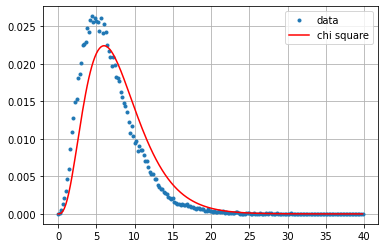

In [1663]:
k = len(timestamplist)//2
hist = (omnibus(vv_list.slice(0,k))
        .reduceRegion(ee.Reducer.fixedHistogram(0, 40, 200), geometry=aoi, scale=10)
        .get('constant')
        .getInfo())

a = np.array(hist)
x = a[:,0]
y = a[:,1]/np.sum(a[:,1])
plt.plot(x, y, '.', label='data')
plt.plot(x, chi2.pdf(x, k-1)/5, '-r', label='chi square')
plt.legend()
plt.grid()
plt.show()

### Initial Change Map 
- Hint: Zoom in and out to see how the changes differ at all zoom levels. Both red and cyan colors indicate change, but the cyan is more consistent with all zoom levels. 
- Hint: If the landslide is coastal, you might see large amounts of change overlapping the ocean... this is due to the constant motion of waves.

In [1664]:
def chi2cdf(chi2, df):
    """Calculates Chi square cumulative distribution function for
       df degrees of freedom using the built-in incomplete gamma
       function gammainc().
    """

    return ee.Image(chi2.divide(2)).gammainc(ee.Number(df).divide(2))

In [1665]:
# Change map for alpha = 0.01.
k = len(timestamplist); alpha = 0.01
p_value = ee.Image.constant(1).subtract(chi2cdf(omnibus(vv_list), k-1))
c_map = p_value.multiply(0).where(p_value.lt(alpha), 1)

# Make the no-change pixels transparent.
c_map = c_map.updateMask(c_map.gt(0))

# Create initial change map.
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=15)
mp.add_ee_layer(c_map, {'min': 0,'max': 1, 'palette': ['black', 'red']}, 'change map')

# Make sure you can see changes correctly at all zoom levels
c_map_10m = c_map.reproject(c_map.projection().crs(), scale=10)
mp = folium.Map(location=location, zoom_start=15)
mp.add_ee_layer(c_map, {'min': 0, 'max': 1, 'palette': ['black', 'red']}, 'Change map')
mp.add_ee_layer(c_map_10m, {'min': 0, 'max': 1, 'palette': ['black', 'cyan']}, 'Change map (10m)')

mp.add_child(folium.LayerControl())

## Create Final Change Map (where and when changes occur)

In the cells below we will develop a product of independent likelihood ratio tests which will enable us to determine when changes occurred at each pixel location. Then we'll code a complete multitemporal change detection algorithm on the GEE Python API.

#### Create a sequential omnibus test

In [1666]:
def sample_vv_imgs(j):
    """Samples the test statistics Rj in the region aoi."""
    j = ee.Number(j)
    # Get the factors in the expression for Rj.
    sj = vv_list.get(j.subtract(1))
    jfact = j.pow(j).divide(j.subtract(1).pow(j.subtract(1)))
    sumj = ee.ImageCollection(vv_list.slice(0, j)).reduce(ee.Reducer.sum())
    sumjm1 = ee.ImageCollection(vv_list.slice(0, j.subtract(1))).reduce(ee.Reducer.sum())
    # Put them together.
    Rj = sumjm1.pow(j.subtract(1)).multiply(sj).multiply(jfact).divide(sumj.pow(j)).pow(5)
    # Sample Rj.
    sample = (Rj.sample(region=aoi, scale=10, numPixels=1000, seed=123)
              .aggregate_array('VV_sum'))
    return sample

# Sample the first few list indices.
samples = ee.List.sequence(2, 5).map(sample_vv_imgs)

# Calculate and display the correlation matrix.
np.set_printoptions(precision=2, suppress=True)

#### Perform map operations on the indices l and j. Return an array of P values.

In [1667]:
def log_det_sum(im_list, j):
    """Returns log of determinant of the sum of the first j images in im_list."""
    im_ist = ee.List(im_list)
    sumj = ee.ImageCollection(im_list.slice(0, j)).reduce(ee.Reducer.sum())
    return ee.Image(det(sumj)).log()

def log_det(im_list, j):
    """Returns log of the determinant of the jth image in im_list."""
    im = ee.Image(ee.List(im_list).get(j.subtract(1)))
    return ee.Image(det(im)).log()

def pval(im_list, j, m=4.4):
    """Calculates -2logRj for im_list and returns P value and -2logRj."""
    im_list = ee.List(im_list)
    j = ee.Number(j)
    m2logRj = (log_det_sum(im_list, j.subtract(1))
               .multiply(j.subtract(1))
               .add(log_det(im_list, j))
               .add(ee.Number(2).multiply(j).multiply(j.log()))
               .subtract(ee.Number(2).multiply(j.subtract(1))
               .multiply(j.subtract(1).log()))
               .subtract(log_det_sum(im_list,j).multiply(j))
               .multiply(-2).multiply(m))
    pv = ee.Image.constant(1).subtract(chi2cdf(m2logRj, 2))
    return (pv, m2logRj)

def p_values(im_list):
    """Pre-calculates the P-value array for a list of images."""
    im_list = ee.List(im_list)
    k = im_list.length()

    def ells_map(ell):
        """Arranges calculation of pval for combinations of k and j."""
        ell = ee.Number(ell)
        # Slice the series from k-l+1 to k (image indices start from 0).
        im_list_ell = im_list.slice(k.subtract(ell), k)

        def js_map(j):
            """Applies pval calculation for combinations of k and j."""
            j = ee.Number(j)
            pv1, m2logRj1 = pval(im_list_ell, j)
            return ee.Feature(None, {'pv': pv1, 'm2logRj': m2logRj1})

        # Map over j=2,3,...,l.
        js = ee.List.sequence(2, ell)
        pv_m2logRj = ee.FeatureCollection(js.map(js_map))

        # Calculate m2logQl from collection of m2logRj images.
        m2logQl = ee.ImageCollection(pv_m2logRj.aggregate_array('m2logRj')).sum()
        pvQl = ee.Image.constant(1).subtract(chi2cdf(m2logQl, ell.subtract(1).multiply(2)))
        pvs = ee.List(pv_m2logRj.aggregate_array('pv')).add(pvQl)
        return pvs

    # Map over l = k to 2.
    ells = ee.List.sequence(k, 2, -1)
    pv_arr = ells.map(ells_map)

    # Return the P value array ell = k,...,2, j = 2,...,l.
    return pv_arr

#### Filtering the _P_ values

|Table 3.2 |       |       |       |       |       |        |
|----------|-------|-------|-------|-------|-------|--------|
|$i\ $ / $j$|      |     1 |     2 |     3 |     4 |        |
| 1        |       | $P_2$ | $P_3$ | $P_4$ | $P_5$ | $P_{Q5}$  |
| 2        |       |       | $P_2$ | $P_3$ | $P_4$ | $P_{Q4}$  |
| 3        |       |       |       | $P_2$ | $P_3$ | $P_{Q3}$  |
| 4        |       |       |       |       | $P_2$ | $P_{Q2}$  |

The pre-calculated _P_ values in _pv\_arr_ (shown schematically in Table 3.2 for $k=5$) are then scanned in nested iterations over indices $i$ and $j$ to determine the following thematic change maps:

- cmap: the interval of the most recent change, one band, byte values $\in [0,k-1]$,
- smap: the interval of the first change, one band, byte values $\in [0,k-1]$,
- fmap: the number of changes, one band, byte values $\in [0,k-1]$,
- bmap: the changes in each interval, $\ k-1$ bands, byte values $\in [0,1]$).

A boolean variable _median_ is included in the code. Its purpose is to reduce the salt-and-pepper effect in no-change regions, which is at least partly a consequence of the uniform distribution of the _P_ values under $H_0$ (see the section [A note on P values](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-2#a_note_on_p_values) in Part 2). If _median_ is _True_, the _P_ values for each $Q_\ell$ statistic are passed through a $5\times 5$ median filter before being compared with the significance threshold. This is not statistically kosher but probably justifiable if one is only interested in large homogeneous changes, for example flood inundations or deforestation.

Here is the code:

In [1668]:
def filter_j(current, prev):
    """Calculates change maps; iterates over j indices of pv_arr."""
    pv = ee.Image(current)
    prev = ee.Dictionary(prev)
    pvQ = ee.Image(prev.get('pvQ'))
    i = ee.Number(prev.get('i'))
    cmap = ee.Image(prev.get('cmap'))
    smap = ee.Image(prev.get('smap'))
    fmap = ee.Image(prev.get('fmap'))
    bmap = ee.Image(prev.get('bmap'))
    alpha = ee.Image(prev.get('alpha'))
    j = ee.Number(prev.get('j'))
    cmapj = cmap.multiply(0).add(i.add(j).subtract(1))
    # Check      Rj?            Ql?                  Row i?
    tst = pv.lt(alpha).And(pvQ.lt(alpha)).And(cmap.eq(i.subtract(1)))
    # Then update cmap...
    cmap = cmap.where(tst, cmapj)
    # ...and fmap...
    fmap = fmap.where(tst, fmap.add(1))
    # ...and smap only if in first row.
    smap = ee.Algorithms.If(i.eq(1), smap.where(tst, cmapj), smap)
    # Create bmap band and add it to bmap image.
    idx = i.add(j).subtract(2)
    tmp = bmap.select(idx)
    bname = bmap.bandNames().get(idx)
    tmp = tmp.where(tst, 1)
    tmp = tmp.rename([bname])
    bmap = bmap.addBands(tmp, [bname], True)
    return ee.Dictionary({'i': i, 'j': j.add(1), 'alpha': alpha, 'pvQ': pvQ,
                          'cmap': cmap, 'smap': smap, 'fmap': fmap, 'bmap':bmap})

def filter_i(current, prev):
    """Arranges calculation of change maps; iterates over row-indices of pv_arr."""
    current = ee.List(current)
    pvs = current.slice(0, -1 )
    pvQ = ee.Image(current.get(-1))
    prev = ee.Dictionary(prev)
    i = ee.Number(prev.get('i'))
    alpha = ee.Image(prev.get('alpha'))
    median = prev.get('median')
    # Filter Ql p value if desired.
    pvQ = ee.Algorithms.If(median, pvQ.focalMedian(2.5), pvQ)
    cmap = prev.get('cmap')
    smap = prev.get('smap')
    fmap = prev.get('fmap')
    bmap = prev.get('bmap')
    first = ee.Dictionary({'i': i, 'j': 1, 'alpha': alpha ,'pvQ': pvQ,
                           'cmap': cmap, 'smap': smap, 'fmap': fmap, 'bmap': bmap})
    result = ee.Dictionary(ee.List(pvs).iterate(filter_j, first))
    return ee.Dictionary({'i': i.add(1), 'alpha': alpha, 'median': median,
                          'cmap': result.get('cmap'), 'smap': result.get('smap'),
                          'fmap': result.get('fmap'), 'bmap': result.get('bmap')})

#### Post-processing: The Loewner order

Create bmap: the map of changes detected in each interval.

The function _dmap\_iter_ below is iterated over the bands of _bmap_, replacing the values for changed pixels with

- 1 for positive definite differences,
- 2 for negative definite differences,
- 3 for indefinite differences.

In [1669]:
def dmap_iter(current, prev):
    """Reclassifies values in directional change maps."""
    prev = ee.Dictionary(prev)
    j = ee.Number(prev.get('j'))
    image = ee.Image(current)
    avimg = ee.Image(prev.get('avimg'))
    diff = image.subtract(avimg)
    
    # Get positive/negative definiteness.
    posd = ee.Image(diff.select(0).gt(0).And(det(diff).gt(0)))
    negd = ee.Image(diff.select(0).lt(0).And(det(diff).gt(0)))
    bmap = ee.Image(prev.get('bmap'))
    bmapj = bmap.select(j)
    dmap = ee.Image.constant(ee.List.sequence(1, 3))
    bmapj = bmapj.where(bmapj, dmap.select(2))
    bmapj = bmapj.where(bmapj.And(posd), dmap.select(0))
    bmapj = bmapj.where(bmapj.And(negd), dmap.select(1))
    bmap = bmap.addBands(bmapj, overwrite=True)
    
    # Update avimg with provisional means.
    i = ee.Image(prev.get('i')).add(1)
    avimg = avimg.add(image.subtract(avimg).divide(i))
    # Reset avimg to current image and set i=1 if change occurred.
    avimg = avimg.where(bmapj, image)
    i = i.where(bmapj, 1)
    return ee.Dictionary({'avimg': avimg, 'bmap': bmap, 'j': j.add(1), 'i': i})

#### Modify the _change\_maps_ function to include the change direction in the _bmap_ image:

In [1670]:
def change_maps(im_list, median=False, alpha=0.01):
    """Calculates thematic change maps."""
    k = im_list.length()
    # Pre-calculate the P value array.
    pv_arr = ee.List(p_values(im_list))
    # Filter P values for change maps.
    cmap = ee.Image(im_list.get(0)).select(0).multiply(0)
    bmap = ee.Image.constant(ee.List.repeat(0,k.subtract(1))).add(cmap)
    alpha = ee.Image.constant(alpha)
    first = ee.Dictionary({'i': 1, 'alpha': alpha, 'median': median,
                           'cmap': cmap, 'smap': cmap, 'fmap': cmap, 'bmap': bmap})
    result = ee.Dictionary(pv_arr.iterate(filter_i, first))
    
    # Post-process bmap for change direction.
    bmap =  ee.Image(result.get('bmap'))
    smap =  ee.Image(result.get('smap'))
    fmap =  ee.Image(result.get('fmap'))
    avimg = ee.Image(im_list.get(0))
    j = ee.Number(0)
    i = ee.Image.constant(1)
    first = ee.Dictionary({
        'avimg': avimg, 'bmap': bmap,'smap': smap, 'fmap': fmap,
        'j': j, 'i': i})
    dmap = ee.Dictionary(im_list.slice(1).iterate(dmap_iter, first)).get('bmap')
    return ee.Dictionary(result.set('bmap', dmap))

#### Export all of the change maps to a single image.

In [1671]:
def plot_change_maps(im_list):
    """Compute and plot change maps"""

    # Run the algorithm with median filter and at 1% significance.
    result = ee.Dictionary(change_maps(im_list, median=True, alpha=0.01))

    # Extract the change maps and export to assets.
    cmap = ee.Image(result.get('cmap'))
    smap = ee.Image(result.get('smap'))
    fmap = ee.Image(result.get('fmap'))
    bmap = ee.Image(result.get('bmap'))
    cmaps = (
        ee.Image
        .cat(cmap, smap, fmap, bmap)
        .rename(['cmap', 'smap', 'fmap']+timestamplist[1:]))
    cmaps = cmaps.updateMask(cmaps.gt(0))
    location = aoi.centroid().coordinates().getInfo()[::-1]

    # create parameters for cmap
    palette = ['black', 'cyan']
    params = {'min': 0, 'max': 1, 'palette': palette}

    # create map with layers

    Map = geemap.Map(location=location, zoom_start=15)
    
    # Different basemaps. you can select or deselect on image itself
    Map.add_basemap('SATELLITE')
    Map.add_basemap('USGS NAIP Imagery NDVI')
    Map.add_basemap('USGS NAIP Imagery False Color')
    
    # Our Cmaps layer
    Map.addLayer(cmaps.select(slide_image), params, 'slide_image')
    

    return Map

In [1672]:
plot_change_maps(im_list)

# Summary

The definite (cyan) changes correspond to decreases and increases in intensity of VV and VH reflectance and are due to displaced land caused by landslides. As we can tell, areas of definite change do correspond to some locations identified on our verified landslide catalog. One location in particular (slide I.D. # 9734 Big Sur) is an area that our change detection map showed a correlation with the verified landlsides catalog. When displayed over the Earth Engine basemap "USGS NAIP Imagery NDVI", you can see this correlation. Other areas were harder to detect. This is possibly an error due to aoi bounds (our verified landslides database could have had approximate locations).

# Outlook 

This study shows us that it is possible that SAR imagery can be utilized to detect landslide motion. One possible application is rapid detection. In this notebook we displayed each change map with the color red. It is possible to display the different individual change maps with different colors. This could help determine locations wtih motion pre-landslide (smap: or interval with first change), which could help inform areas of high landslide risk.

# References

Copyright 2022 Mitchel Thompson and Leah Manak

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at:

<http://www.apache.org/licenses/LICENSE-2.0>

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

[1] < https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/>